In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency, kruskal
from statannotations.Annotator import Annotator

from SSNHL.util import load_data

In [2]:
raw_data = load_data('../raw_data/all.xlsx', preprocess_func=None)
raw_data = raw_data.rename(columns={'prognostic(no_recovery=0, minor_recovery=1, important_recovery=2, full_recovery=3)': 'prognostic'})
raw_data

,Gender,Age,Left ear/Right ear,Days from onset to treatment(absolute),days from onset to treatment (categorized),Vertigo,Ear blockage,Tinnitus,Hypertension,Diabetes,...,Mean hearing threshold (affected side),WHO classify (affected side),Curve type (affected side),Mean hearing threshold (contralateral),WHO classify (contralateral),Curve type (contralateral),loudness recruitment(affected side),ABR,DPOAE response,prognostic
patient NO.,,,,,,,,,,,,,,,,,,,,,
4,0,28,R,1,0,0,1,1,0,0,...,49.0,2,upsloping,-1.0,0.0,normal,1.0,0.0,1.0,3
455,0,33,L,15,2,0,1,1,0,0,...,18.0,0,upsloping,0.0,0.0,normal,1.0,0.0,1.0,0
405,0,30,L,10,1,1,0,1,0,0,...,105.0,4,profound,1.0,0.0,normal,0.0,1.0,0.0,0
264,0,27,R,6,0,1,1,1,0,0,...,21.0,0,upsloping,3.0,0.0,normal,1.0,0.0,1.0,3
458,0,29,R,15,2,0,1,1,0,0,...,23.0,0,upsloping,3.0,0.0,normal,0.0,NaN,1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,0,75,L,5,0,0,1,0,0,0,...,200.0,4,profound,200.0,4.0,profound,0.0,1.0,0.0,0
476,0,42,L,20,2,0,1,1,0,0,...,18.0,0,upsloping,NaN,NaN,normal,1.0,0.0,1.0,3
489,1,54,L,20,2,0,1,1,0,0,...,74.0,3,flat,NaN,NaN,NaN,0.0,NaN,NaN,0


In [3]:
data = raw_data.copy()
data = data.fillna('-')

data.loc[data['prognostic'] == 0, 'prognostic'] = 'no recovery'
data.loc[data['prognostic'] == 1, 'prognostic'] = 'minor recovery'
data.loc[data['prognostic'] == 2, 'prognostic'] = 'important recovery'
data.loc[data['prognostic'] == 3, 'prognostic'] = 'full recovery'
data['prognostic'] = pd.Categorical(data['prognostic'], ['no recovery', 'minor recovery', 'important recovery', 'full recovery'])

data

,Gender,Age,Left ear/Right ear,Days from onset to treatment(absolute),days from onset to treatment (categorized),Vertigo,Ear blockage,Tinnitus,Hypertension,Diabetes,...,Mean hearing threshold (affected side),WHO classify (affected side),Curve type (affected side),Mean hearing threshold (contralateral),WHO classify (contralateral),Curve type (contralateral),loudness recruitment(affected side),ABR,DPOAE response,prognostic
patient NO.,,,,,,,,,,,,,,,,,,,,,
4,0,28,R,1,0,0,1,1,0,0,...,49.0,2,upsloping,-1.0,0.0,normal,1.0,0.0,1.0,full recovery
455,0,33,L,15,2,0,1,1,0,0,...,18.0,0,upsloping,0.0,0.0,normal,1.0,0.0,1.0,no recovery
405,0,30,L,10,1,1,0,1,0,0,...,105.0,4,profound,1.0,0.0,normal,0.0,1.0,0.0,no recovery
264,0,27,R,6,0,1,1,1,0,0,...,21.0,0,upsloping,3.0,0.0,normal,1.0,0.0,1.0,full recovery
458,0,29,R,15,2,0,1,1,0,0,...,23.0,0,upsloping,3.0,0.0,normal,0.0,-,1.0,full recovery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,0,75,L,5,0,0,1,0,0,0,...,200.0,4,profound,200.0,4.0,profound,0.0,1.0,0.0,no recovery
476,0,42,L,20,2,0,1,1,0,0,...,18.0,0,upsloping,-,-,normal,1.0,0.0,1.0,full recovery
489,1,54,L,20,2,0,1,1,0,0,...,74.0,3,flat,-,-,-,0.0,-,-,no recovery


In [4]:
discrete_value_columns = data.columns[data.nunique() < 10].drop('prognostic')
consecutive_value_columns = data.columns[data.nunique() >= 10]

In [5]:
df = pd.DataFrame()
for column in discrete_value_columns:
    _data = data.copy()

    _df = pd.crosstab(_data[column], _data['prognostic'], rownames=['value']).reset_index()

    stat, p, dof, expected =  chi2_contingency(_df[_df.columns.drop('value')])
    _df['P'] = p

    for efficacy in _data['prognostic'].cat.categories:
        _proportion = (round(_df[efficacy] / _df[efficacy].sum() * 100, 2)).astype(str)
        _df[efficacy] = _df[efficacy].astype(str) + '(' + _proportion + '%)'

    _df['feature'] = column
    _df.set_index(['feature', 'value'], inplace=True)
    df = pd.concat([df, _df])
df.to_csv('../output/distribution/discrete_feature_distribution.csv')
df

prognostic                                              no recovery  \
feature                                    value                      
Gender                                     0            154(50.66%)   
                                           1            150(49.34%)   
Left ear/Right ear                         L            156(51.32%)   
                                           R            148(48.68%)   
days from onset to treatment (categorized) 0            132(43.42%)   
                                           1             52(17.11%)   
                                           2            120(39.47%)   
Vertigo                                    0            194(63.82%)   
                                           1            110(36.18%)   
Ear blockage                               0            140(46.05%)   
                                           1            164(53.95%)   
Tinnitus                                   0              26(8.55%)   
                                           1            278(91.45%)   
Hypertension                               0            236(77.63%)   
                                           1             68(22.37%)   
Diabetes                                   0            276(90.79%)   
                                           1              28(9.21%)   
Tinnitus history                           0            289(95.07%)   
                                           1              15(4.93%)   
Hearing loss history                       0            263(86.51%)   
                                           1             41(13.49%)   
WHO classify (affected side)               0              18(5.92%)   
                                           1             44(14.47%)   
                                           2              76(25.0%)   
                                           3             73(24.01%)   
                                           4             93(30.59%)   
Curve type (affected side)                 downsloping   37(12.17%)   
                                           flat         134(44.08%)   
                                           profound      82(26.97%)   
                                           upsloping     51(16.78%)   
WHO classify (contralateral)               0            217(71.38%)   
                                           1             37(12.17%)   
                                           2              14(4.61%)   
                                           3              13(4.28%)   
                                           4              21(6.91%)   
                                           -               2(0.66%)   
Curve type (contralateral)                 -                7(2.3%)   
                                           downsloping   46(15.13%)   
                                           flat           21(6.91%)   
                                           normal       208(68.42%)   
                                           profound       19(6.25%)   
                                           upsloping       3(0.99%)   
loudness recruitment(affected side)        0            188(61.84%)   
                                           1            100(32.89%)   
                                           -              16(5.26%)   
ABR                                        0            149(49.01%)   
                                           1            137(45.07%)   
                                           -              18(5.92%)   
DPOAE response                             0            198(65.13%)   
                                           1             61(20.07%)   
                                           -              45(14.8%)   

prognostic                                             minor recovery  \
feature                                    value                        
Gender                                     0               41(53.95%)   
                 

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


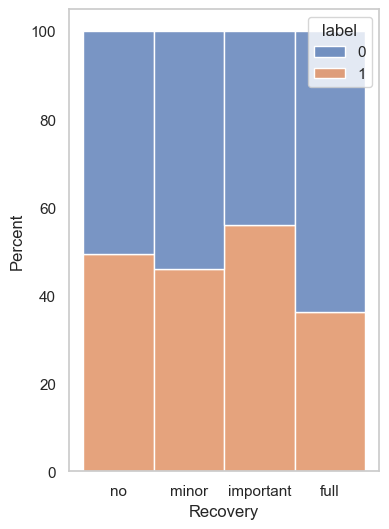

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


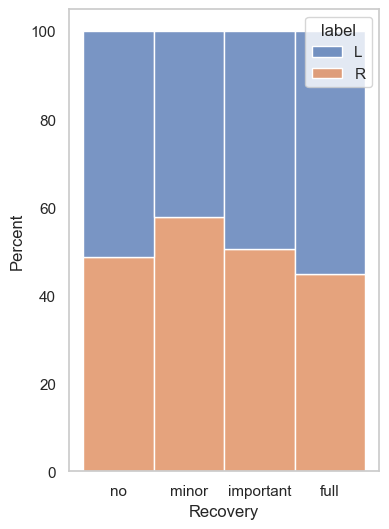

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


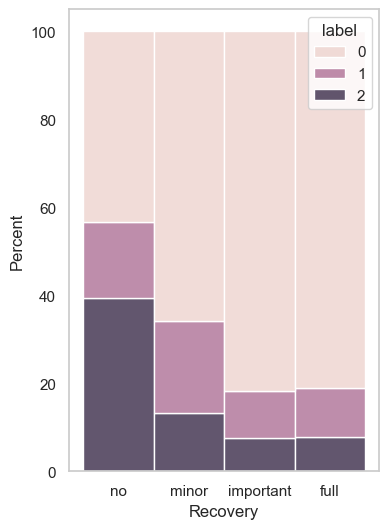

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


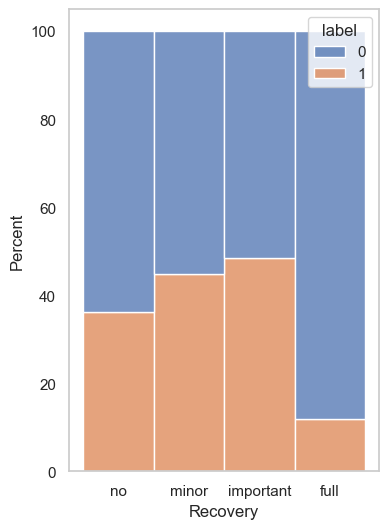

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


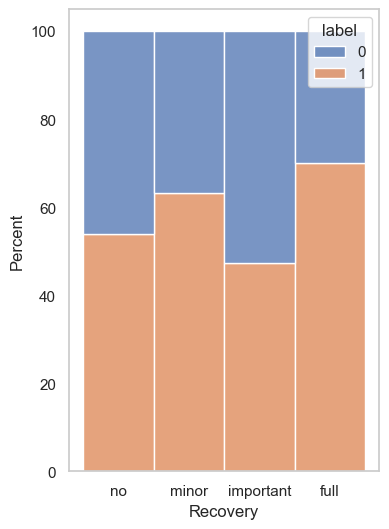

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


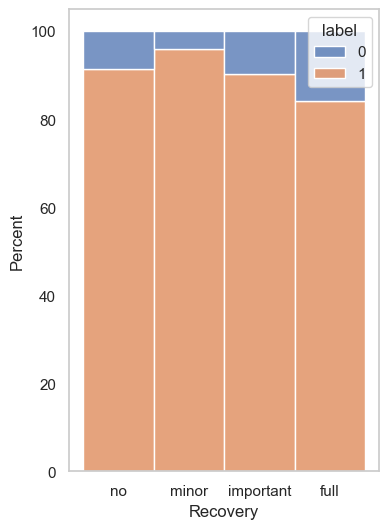

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


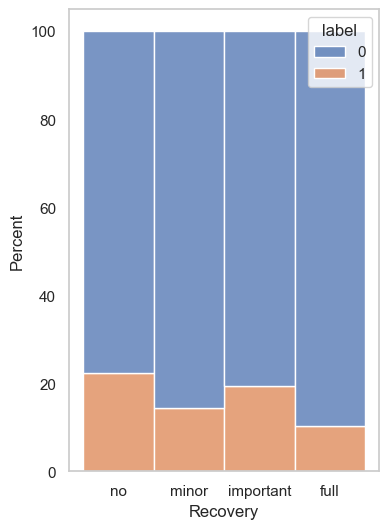

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


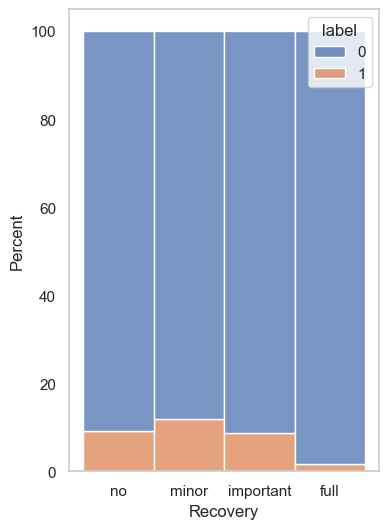

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


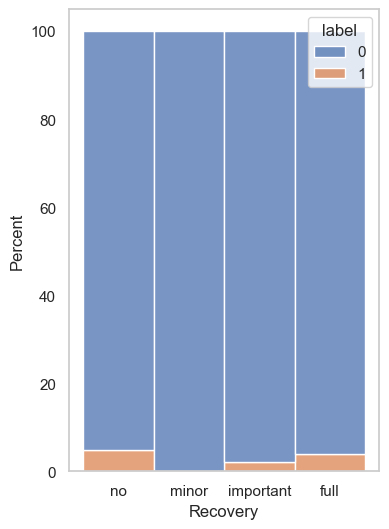

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


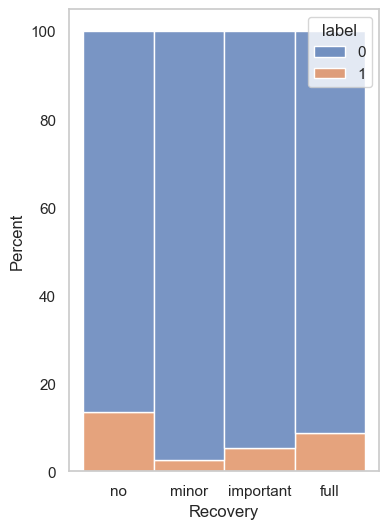

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


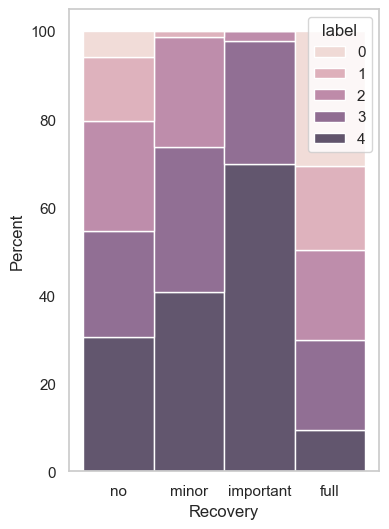

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


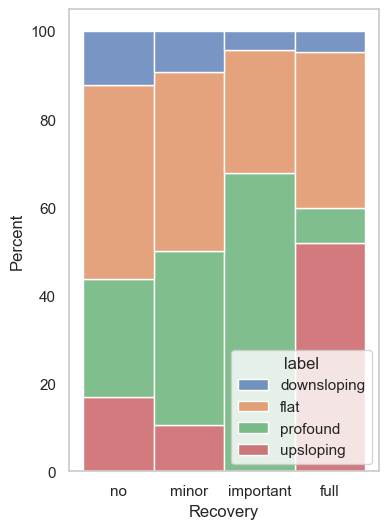

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


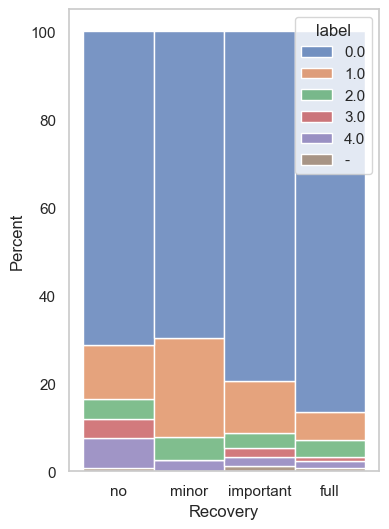

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


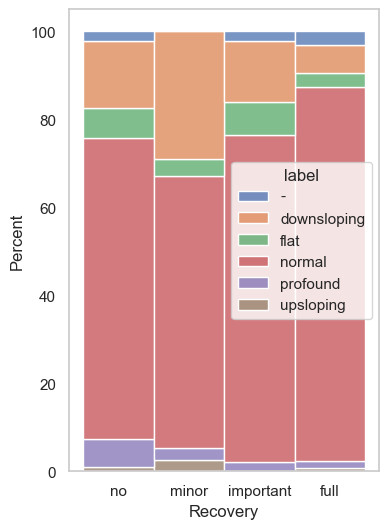

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


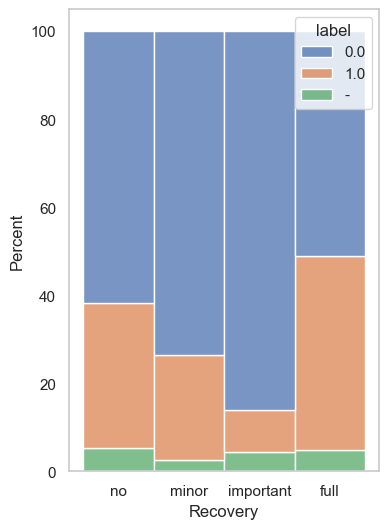

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


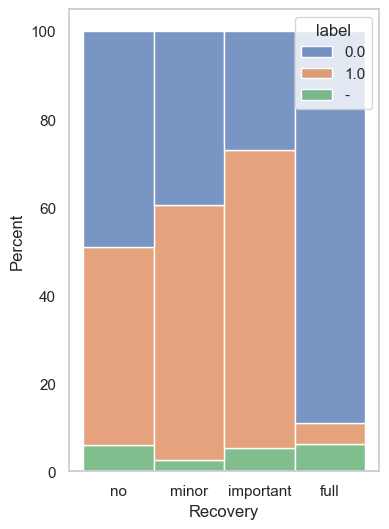

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/3236598090.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels)


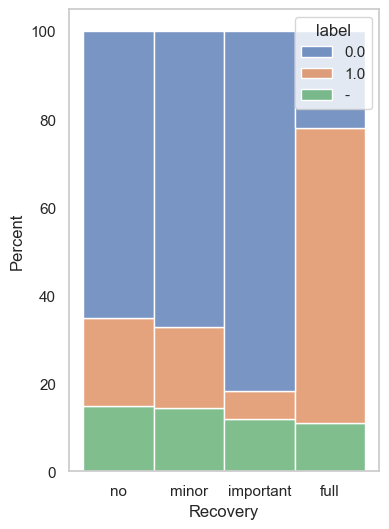

In [6]:
def histplot(data, x=None, y=None, hue=None, weights=None, pairs=None, test=None, xlabel=None, ylabel=None, xticklabels=None, output_path: str = None, figsize: tuple = (24, 12)):
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=figsize)

    ax = sns.histplot(data=data, x=x, y=y, hue=hue, weights=weights, multiple='stack', element='bars', common_norm=False)

    if pairs:
        annotator = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue, plot='barplot')
        annotator.configure(test=test, text_format='star')
        annotator.apply_and_annotate()

    plt.grid(False)

    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if xticklabels:
        ax.set_xticklabels(labels=xticklabels)

    if output_path:
        plt.savefig(output_path, bbox_inches="tight")
    plt.show()


df = pd.DataFrame()
for column in discrete_value_columns:
    _data = data.copy()

    _df = pd.crosstab(_data[column], _data['prognostic'], rownames=['label']).reset_index()
    _df.columns.name = None

    for efficacy in _data['prognostic'].cat.categories:
        _df[efficacy] = round(_df[efficacy] / _df[efficacy].sum() * 100, 2)

    _df['feature'] = column
    df = pd.concat([df, _df])

df = pd.melt(df, value_vars=df.columns, id_vars=['feature', 'label'])
for feature in df['feature'].unique():
    _df = df[df['feature']==feature]

    histplot(
        _df,
        x='variable',
        weights='value',
        hue='label',
        xlabel='Recovery',
        xticklabels=['no', 'minor', 'important', 'full'],
        ylabel='Percent',
        figsize=(4, 6),
        output_path='../output/distribution/discrete/{}_distribution.pdf'.format(feature.replace("/", "\\"))
    )

In [7]:
df = pd.DataFrame()
for column in consecutive_value_columns:
    _data = data[data[column] != '-']

    _df = {}
    column_values = []
    for efficacy in _data['prognostic'].cat.categories:
        _column_values = _data.loc[_data['prognostic'] == efficacy, column]
        _df[efficacy] = '{}({}-{})'.format(round(_column_values.median(), 2), _column_values.min(), _column_values.max())
        column_values.append(_column_values)
    _df = pd.DataFrame([_df])

    stat, p = kruskal(*column_values)
    _df['P'] = p

    _df['feature'] = column
    _df.set_index('feature', inplace=True)
    df = pd.concat([df, _df])
df.to_csv('../output/distribution/consecutive_feature_distribution.csv')
df

,no recovery,minor recovery,important recovery,full recovery,P
feature,,,,,
Age,50.0(18-84),46.5(18-69),51.0(19-72),38.0(18-75),8.509050e-09
Days from onset to treatment(absolute),10.0(1-90),7.0(1-60),4.0(1-60),6.0(1-60),3.529544e-16
White blood cells,8.41(2.79-22.16),8.75(3.77-18.33),8.58(3.34-22.14),8.41(3.37-19.29),4.834182e-01
Hemoglobin,136.5(50.0-172.0),140.0(78.0-177.0),140.0(89.0-178.0),136.0(76.0-180.0),6.306120e-01
Platelet,246.0(136.0-545.0),262.0(97.0-384.0),252.0(57.0-548.0),263.0(152.0-1117.0),3.576524e-01
Fibrinogen,2.61(0.46-8.18),2.48(1.0-4.87),2.55(0.52-5.22),2.37(0.56-4.62),3.074143e-02
Cholesterol,5.16(2.47-8.88),5.3(3.54-9.1),5.19(3.3-8.59),4.94(3.4-7.48),4.454620e-02
Height,1.62(1.41-1.85),1.62(1.43-1.86),1.65(1.41-1.82),1.61(1.42-1.82),4.945221e-01
Weight,61.8(33.9-99.9),58.2(33.1-94.1),61.4(35.6-113.0),59.3(39.1-105.7),4.006211e-01


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Age_important recovery vs. Age_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.019e-04 U_stat=6.517e+03
Age_no recovery vs. Age_minor recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=9.269e+03
Age_minor recovery vs. Age_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.447e+03
Age_minor recovery vs. Age_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.210e-03 U_stat=4.911e+03
Age_no recovery vs. Age_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.102e+04
Age_no recovery vs. Age_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correct

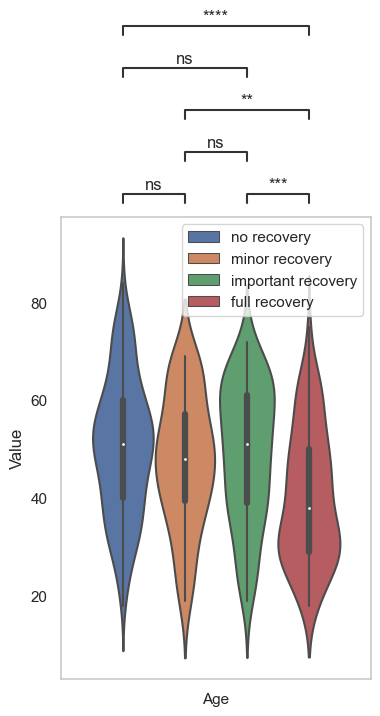

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Days from onset to treatment(absolute)_important recovery vs. Days from onset to treatment(absolute)_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.947e-01 U_stat=4.066e+03
Days from onset to treatment(absolute)_no recovery vs. Days from onset to treatment(absolute)_minor recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:5.466e-02 U_stat=1.018e+04
Days from onset to treatment(absolute)_minor recovery vs. Days from onset to treatment(absolute)_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:7.382e-04 U_stat=3.592e+03
Days from onset to treatment(absolute)_minor recovery vs. Days from onset to treatment(absolute)_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correc

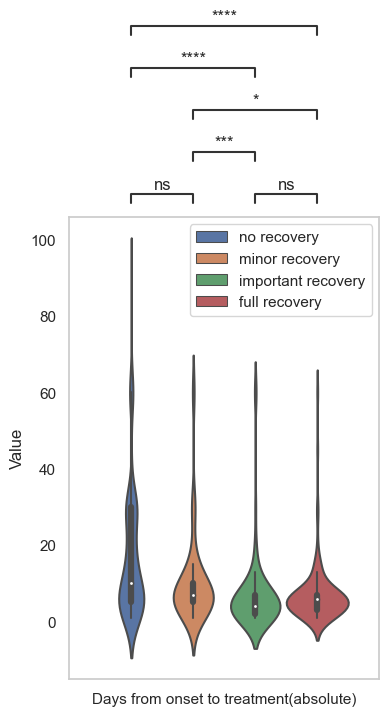

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

White blood cells_important recovery vs. White blood cells_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=5.026e+03
White blood cells_no recovery vs. White blood cells_minor recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=7.926e+03
White blood cells_minor recovery vs. White blood cells_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.516e+03
White blood cells_minor recovery vs. White blood cells_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=3.772e+03
White blood cells_no recovery vs. White blood cells_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni corr

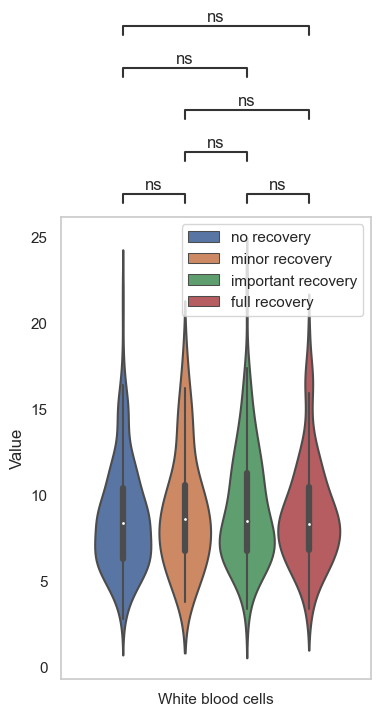

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Hemoglobin_important recovery vs. Hemoglobin_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=5.174e+03
Hemoglobin_no recovery vs. Hemoglobin_minor recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=7.916e+03
Hemoglobin_minor recovery vs. Hemoglobin_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.737e+03
Hemoglobin_minor recovery vs. Hemoglobin_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=4.116e+03
Hemoglobin_no recovery vs. Hemoglobin_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.043e+04
Hemoglobin_no recovery vs. He

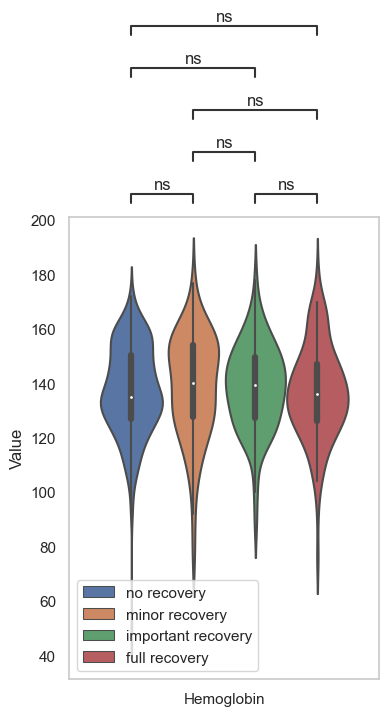

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Platelet_important recovery vs. Platelet_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=4.554e+03
Platelet_no recovery vs. Platelet_minor recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=7.607e+03
Platelet_minor recovery vs. Platelet_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.763e+03
Platelet_minor recovery vs. Platelet_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=3.711e+03
Platelet_no recovery vs. Platelet_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.036e+04
Platelet_no recovery vs. Platelet_full recovery: 

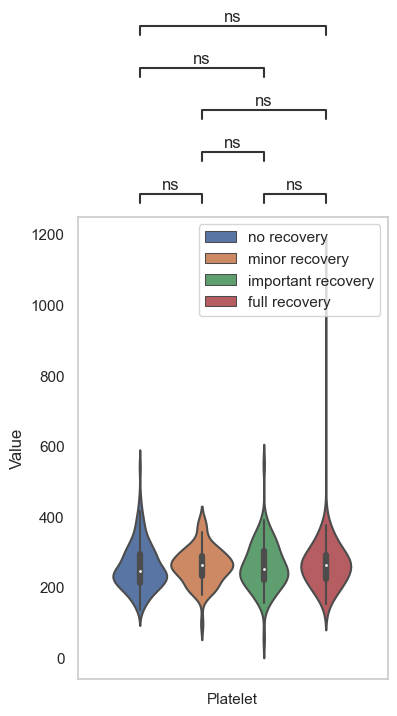

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Fibrinogen_important recovery vs. Fibrinogen_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:7.778e-01 U_stat=5.404e+03
Fibrinogen_no recovery vs. Fibrinogen_minor recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=9.240e+03
Fibrinogen_minor recovery vs. Fibrinogen_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.513e+03
Fibrinogen_minor recovery vs. Fibrinogen_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=3.958e+03
Fibrinogen_no recovery vs. Fibrinogen_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.144e+04
Fibrinogen_no recovery vs. Fi

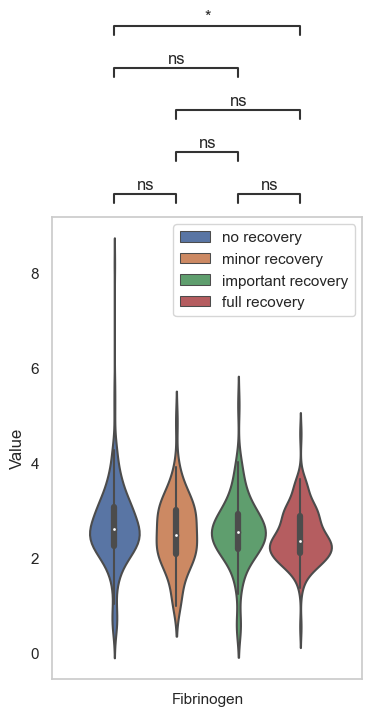

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Cholesterol_important recovery vs. Cholesterol_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.853e-01 U_stat=5.496e+03
Cholesterol_no recovery vs. Cholesterol_minor recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=7.796e+03
Cholesterol_minor recovery vs. Cholesterol_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.809e+03
Cholesterol_minor recovery vs. Cholesterol_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.980e-02 U_stat=4.552e+03
Cholesterol_no recovery vs. Cholesterol_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.072e+04
Cholesterol_no reco

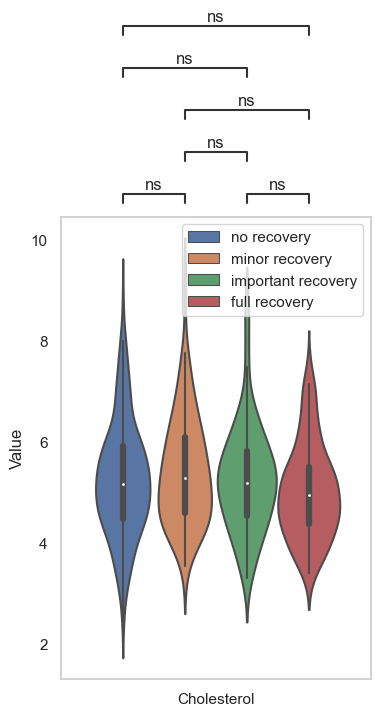

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Height_important recovery vs. Height_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=5.123e+03
Height_no recovery vs. Height_minor recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=8.198e+03
Height_minor recovery vs. Height_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.442e+03
Height_minor recovery vs. Height_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=3.712e+03
Height_no recovery vs. Height_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=9.708e+03
Height_no recovery vs. Height_full recovery: Mann-Whitney-Wilcoxon te

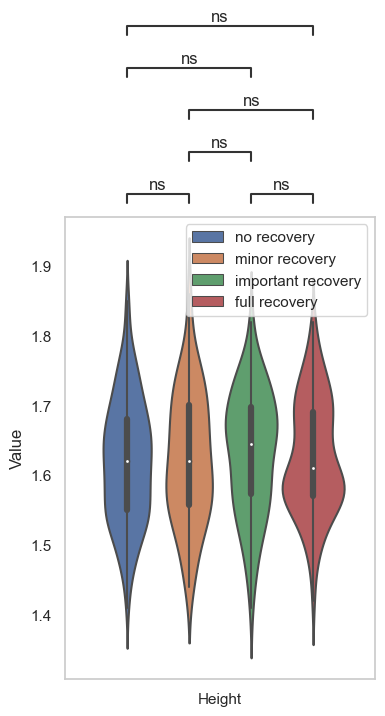

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Weight_important recovery vs. Weight_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=5.228e+03
Weight_no recovery vs. Weight_minor recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=8.476e+03
Weight_minor recovery vs. Weight_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.640e+03
Weight_minor recovery vs. Weight_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=4.091e+03
Weight_no recovery vs. Weight_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.099e+04
Weight_no recovery vs. Weight_full recovery: Mann-Whitney-Wilcoxon te

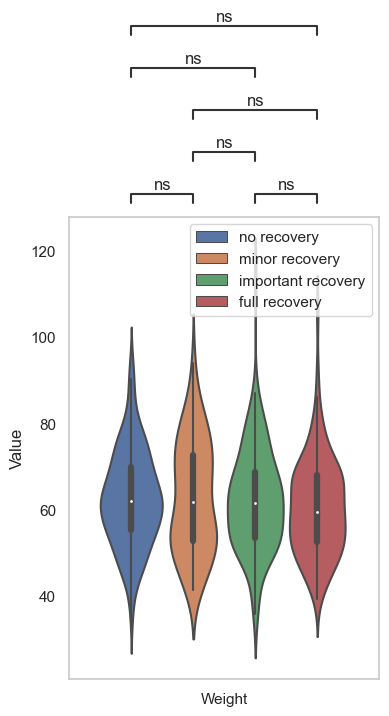

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BMI_important recovery vs. BMI_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=5.224e+03
BMI_no recovery vs. BMI_minor recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=8.680e+03
BMI_minor recovery vs. BMI_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.759e+03
BMI_minor recovery vs. BMI_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.732e-01 U_stat=4.235e+03
BMI_no recovery vs. BMI_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=1.162e+04
BMI_no recovery vs. BMI_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correct

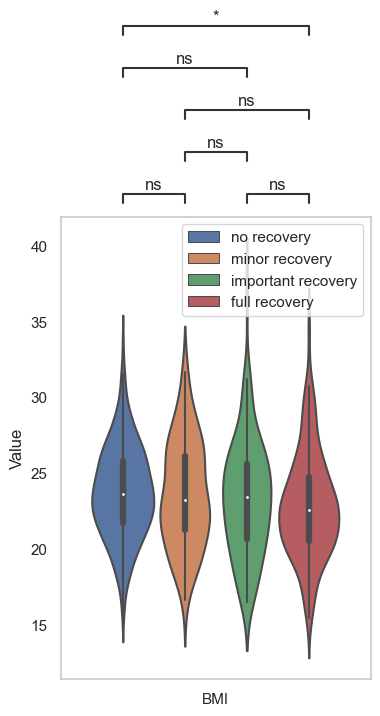

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mean hearing threshold (affected side)_important recovery vs. Mean hearing threshold (affected side)_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.509e-25 U_stat=8.968e+03
Mean hearing threshold (affected side)_no recovery vs. Mean hearing threshold (affected side)_minor recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.456e-02 U_stat=6.360e+03
Mean hearing threshold (affected side)_minor recovery vs. Mean hearing threshold (affected side)_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:9.816e-06 U_stat=1.414e+03
Mean hearing threshold (affected side)_minor recovery vs. Mean hearing threshold (affected side)_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correc

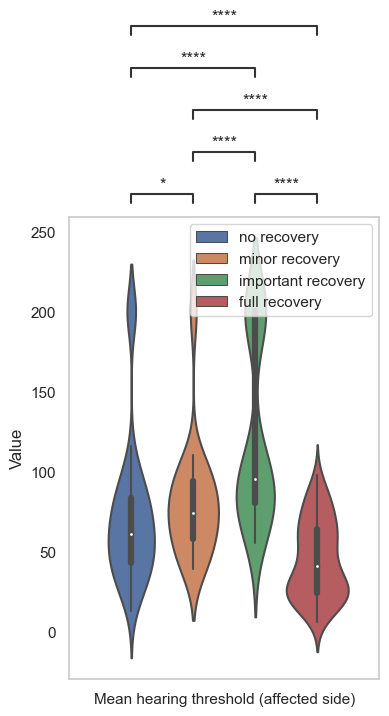

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mean hearing threshold (contralateral)_important recovery vs. Mean hearing threshold (contralateral)_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.558e-03 U_stat=6.142e+03
Mean hearing threshold (contralateral)_no recovery vs. Mean hearing threshold (contralateral)_minor recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=8.922e+03
Mean hearing threshold (contralateral)_minor recovery vs. Mean hearing threshold (contralateral)_important recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=2.698e+03
Mean hearing threshold (contralateral)_minor recovery vs. Mean hearing threshold (contralateral)_full recovery: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correc

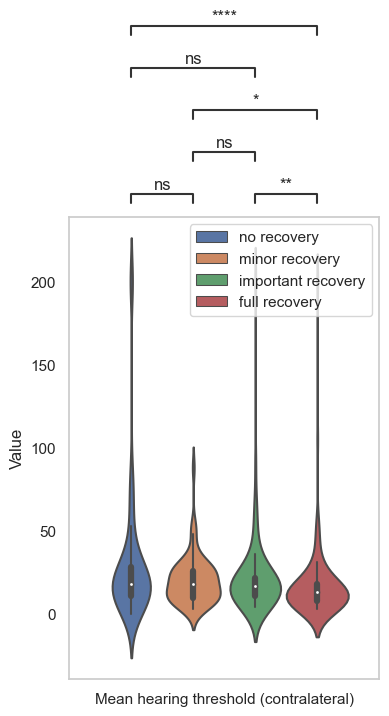

In [8]:
def violinplot(data, x=None, y=None, hue=None, pairs=None, xlabel=None, ylabel=None, xticklabels=None, output_path: str = None, figsize: tuple = (24, 12)):
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots(figsize=figsize)

    ax = sns.violinplot(data=data, x=x, y=y, hue=hue)

    if pairs:
        annotator = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="Bonferroni")
        annotator.apply_and_annotate()

    plt.legend()
    plt.grid(False)

    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if xticklabels:
        ax.set_xticklabels(labels=xticklabels)

    if output_path:
        plt.savefig(output_path, bbox_inches="tight")
    plt.show()


_data = data[consecutive_value_columns].copy()
_data['prognostic'] = data['prognostic']
_data = _data[~_data.apply(lambda row: row.astype(str).str.contains('-').any(), axis=1)]
_data = pd.melt(_data, value_vars=consecutive_value_columns, id_vars=['prognostic'])
_data['value'] = _data['value'].astype(float)


for column in consecutive_value_columns:
    _prognostic = _data['prognostic'].unique()
    pairs = [
        ((column, _prognostic[i]), (column, _prognostic[j]))
        for i in range(len(_prognostic))
        for j in range(i+1, len(_prognostic))
    ]


    violinplot(
        _data[_data['variable']==column],
        x='variable',
        y='value',
        hue='prognostic',
        pairs=pairs,
        xlabel='',
        ylabel='Value',
        # ylabel='Accuracy',
        figsize=(4, 6),
        output_path='../output/distribution/consecutive/{}_distribution.pdf'.format(column.replace("/", "\\")),
    )

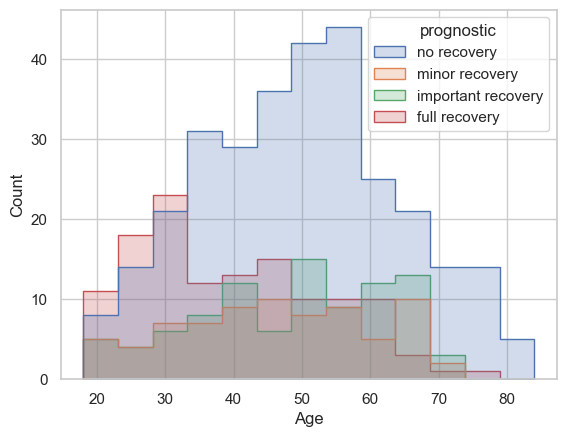

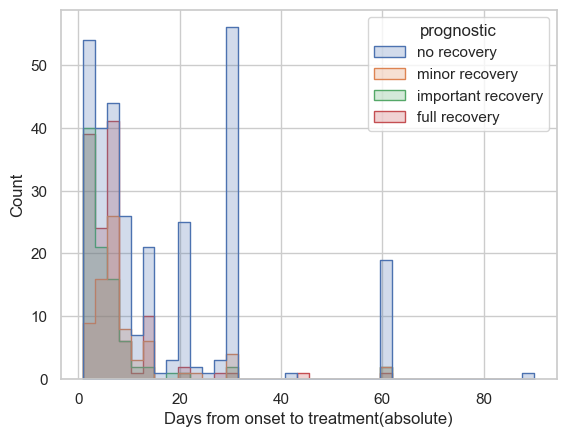

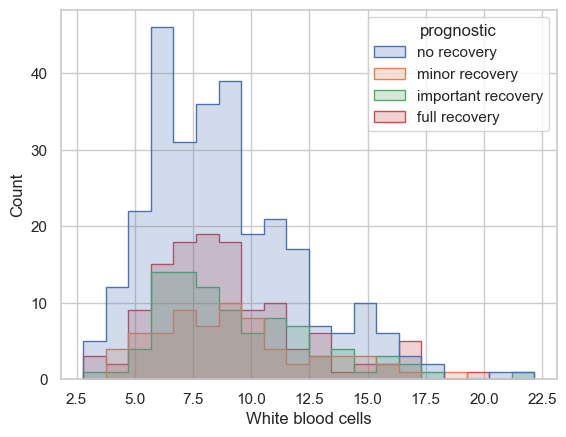

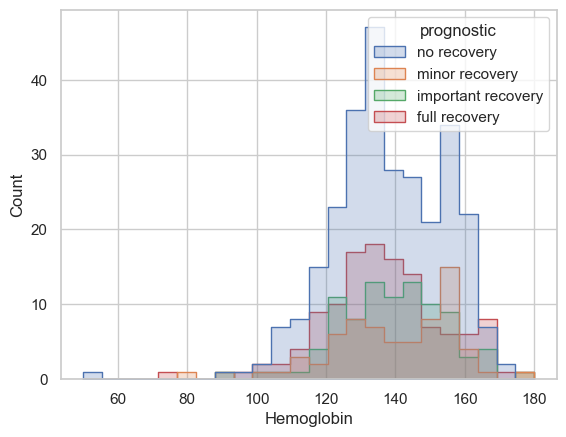

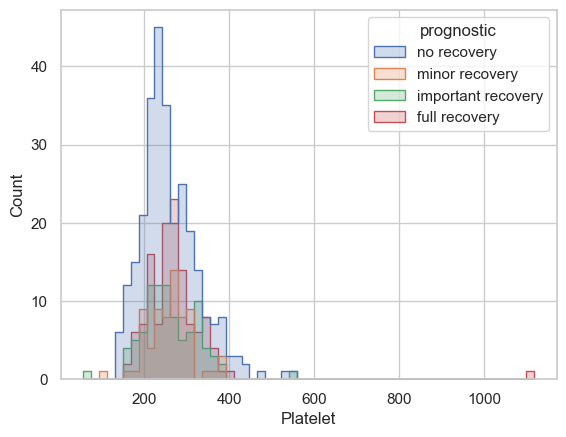

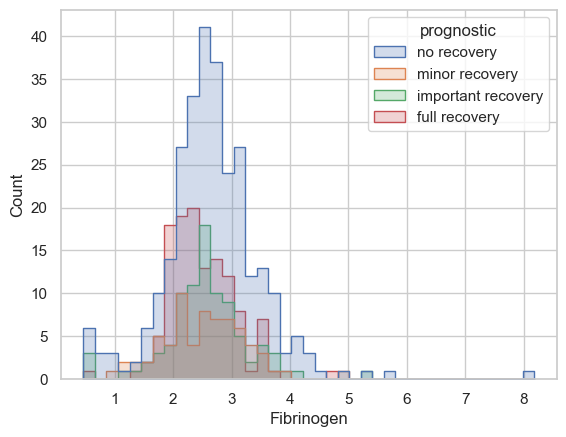

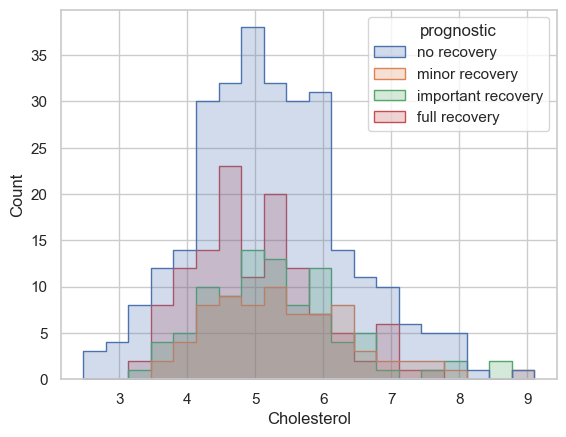

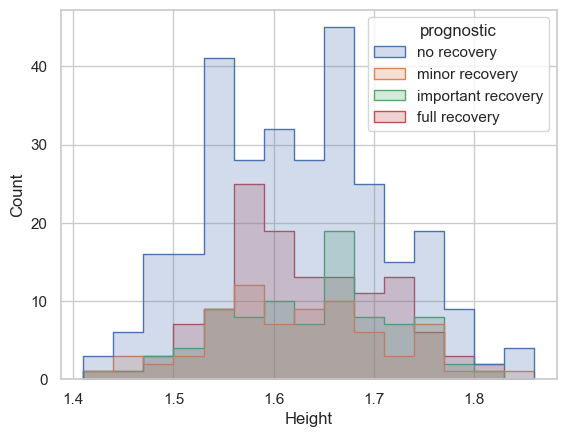

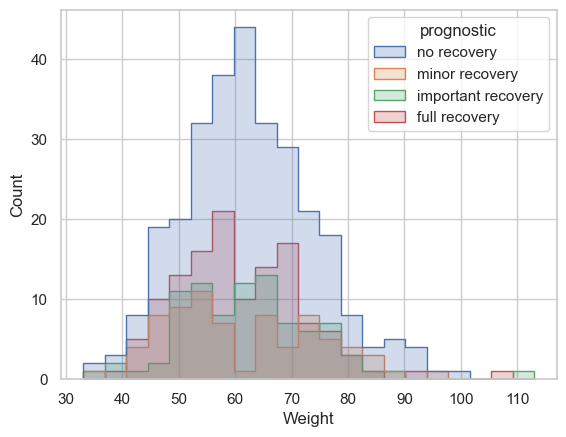

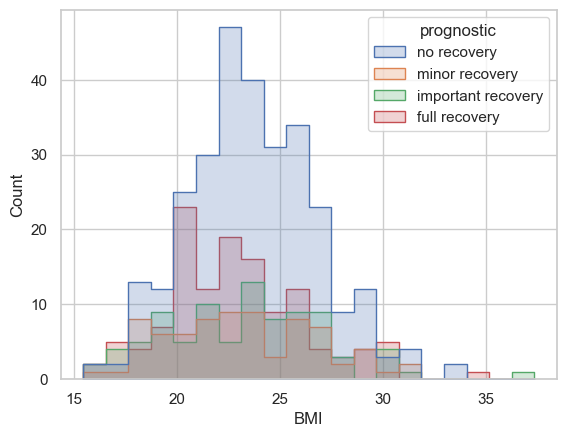

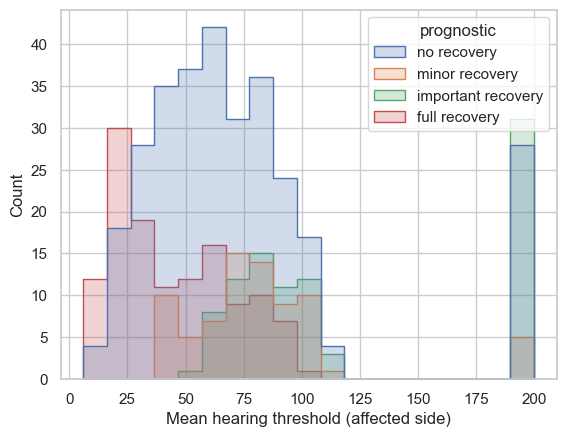

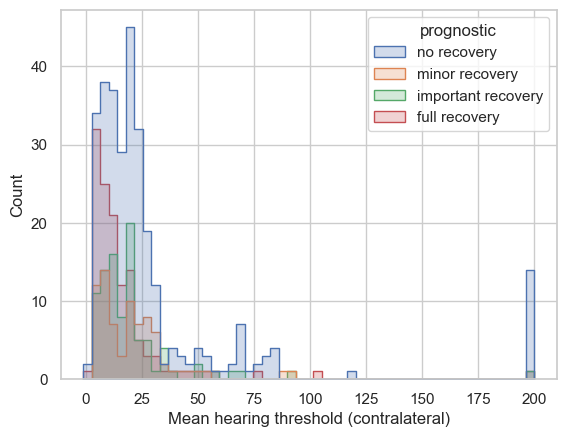

In [9]:
for column in consecutive_value_columns:
    _data = data[data[column] != '-']

    sns.histplot(data=_data, x=column, hue='prognostic', element="step")
    plt.savefig('../output/distribution/{}.pdf'.format(column), bbox_inches="tight")
    plt.show()

In [10]:
df = pd.DataFrame()
for column in data.columns.drop('prognostic'):
    _data = data[[column, 'prognostic']].copy()
    _data = data[data[column] == '-']

    _df = pd.crosstab(_data[column], _data['prognostic'], rownames=['feature']).reset_index()
    _df['feature'] = column
    _df.set_index('feature', inplace=True)
    df = pd.concat([df, _df])
df = df.fillna(0).astype(int)
df.to_csv('../output/distribution/missing_distribution.csv')
df

prognostic,no recovery,minor recovery,important recovery,full recovery
feature,,,,
White blood cells,20,7,2,3
Hemoglobin,22,7,2,4
Platelet,22,7,2,4
Fibrinogen,19,8,4,4
Cholesterol,17,2,2,3
Height,15,1,5,1
Weight,15,1,5,1
BMI,15,1,5,1
Mean hearing threshold (contralateral),2,0,1,1


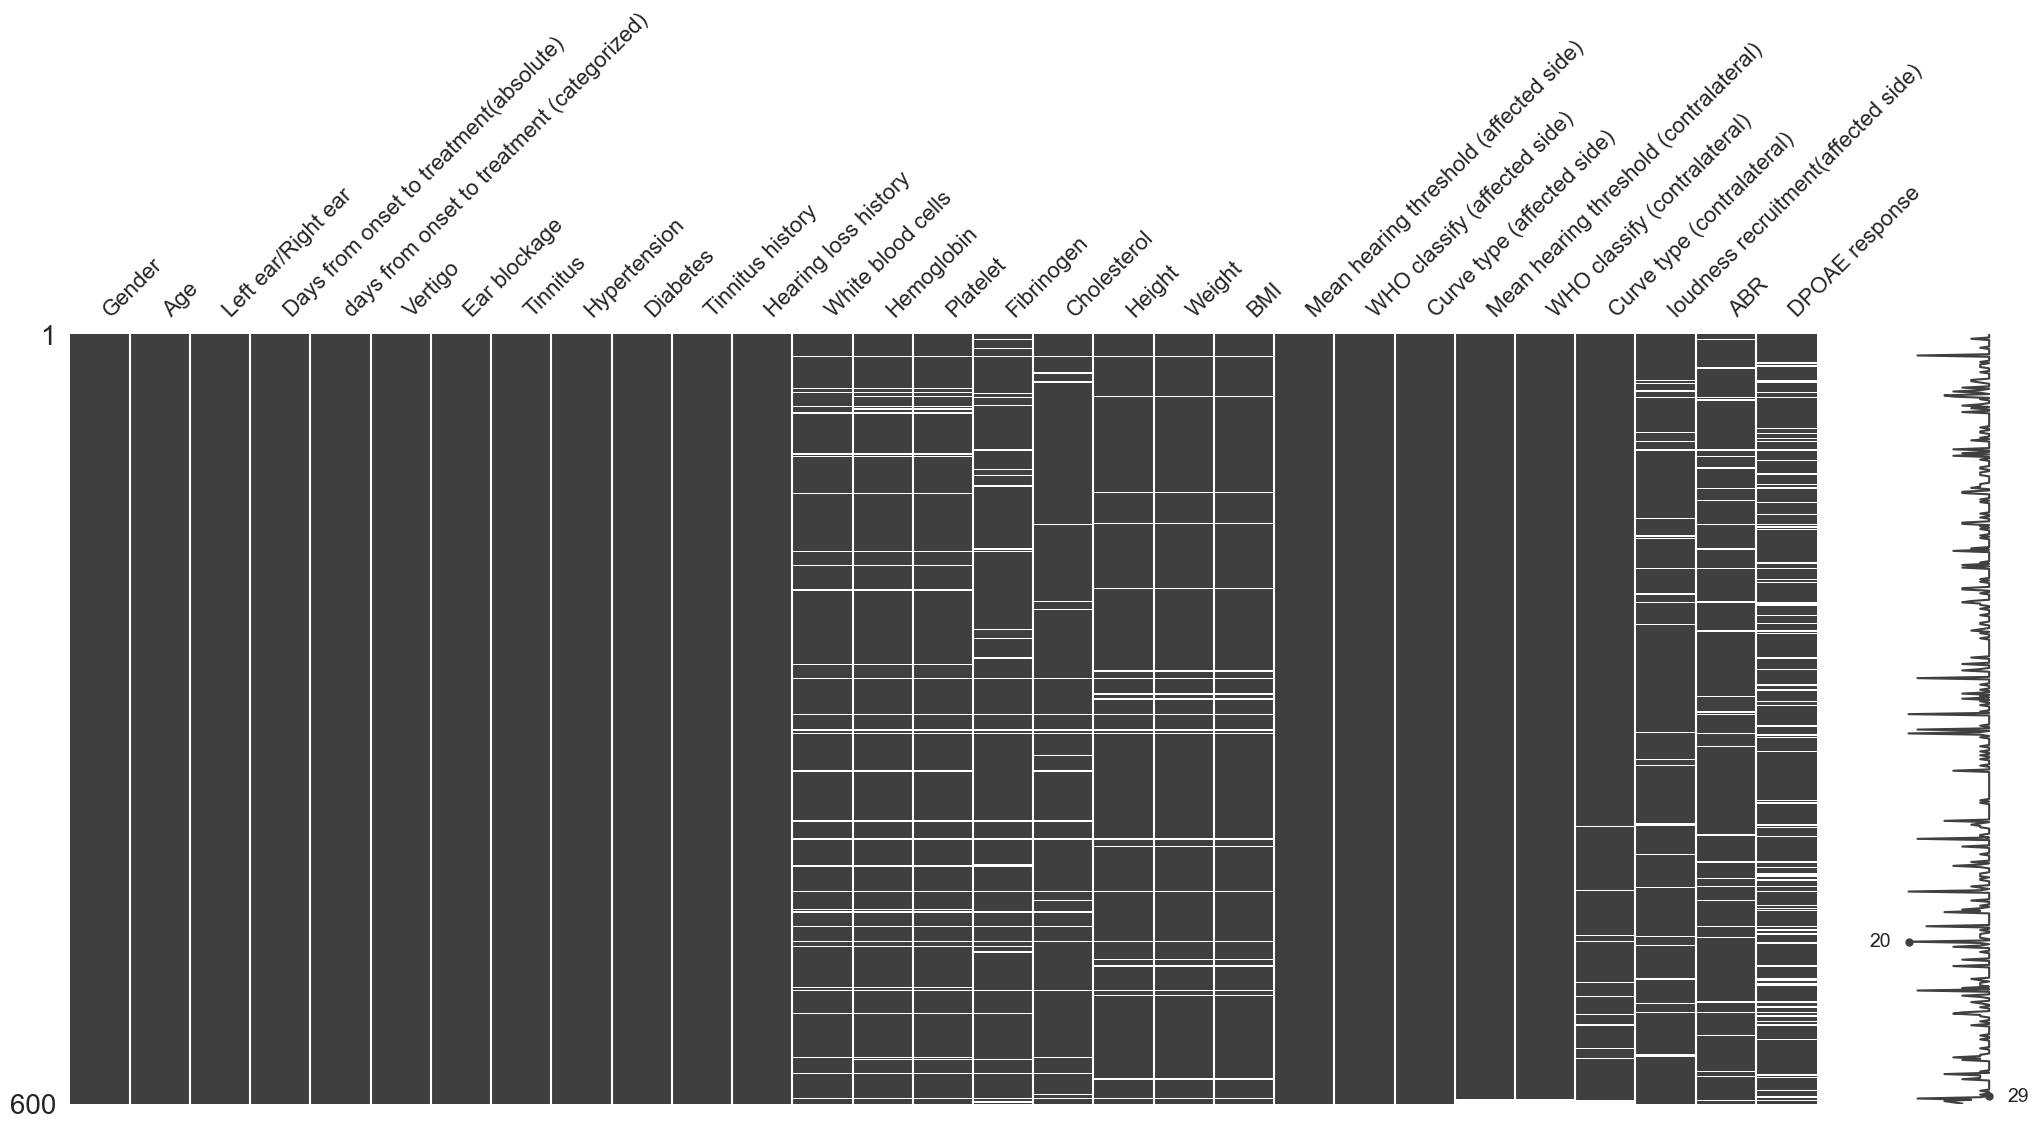

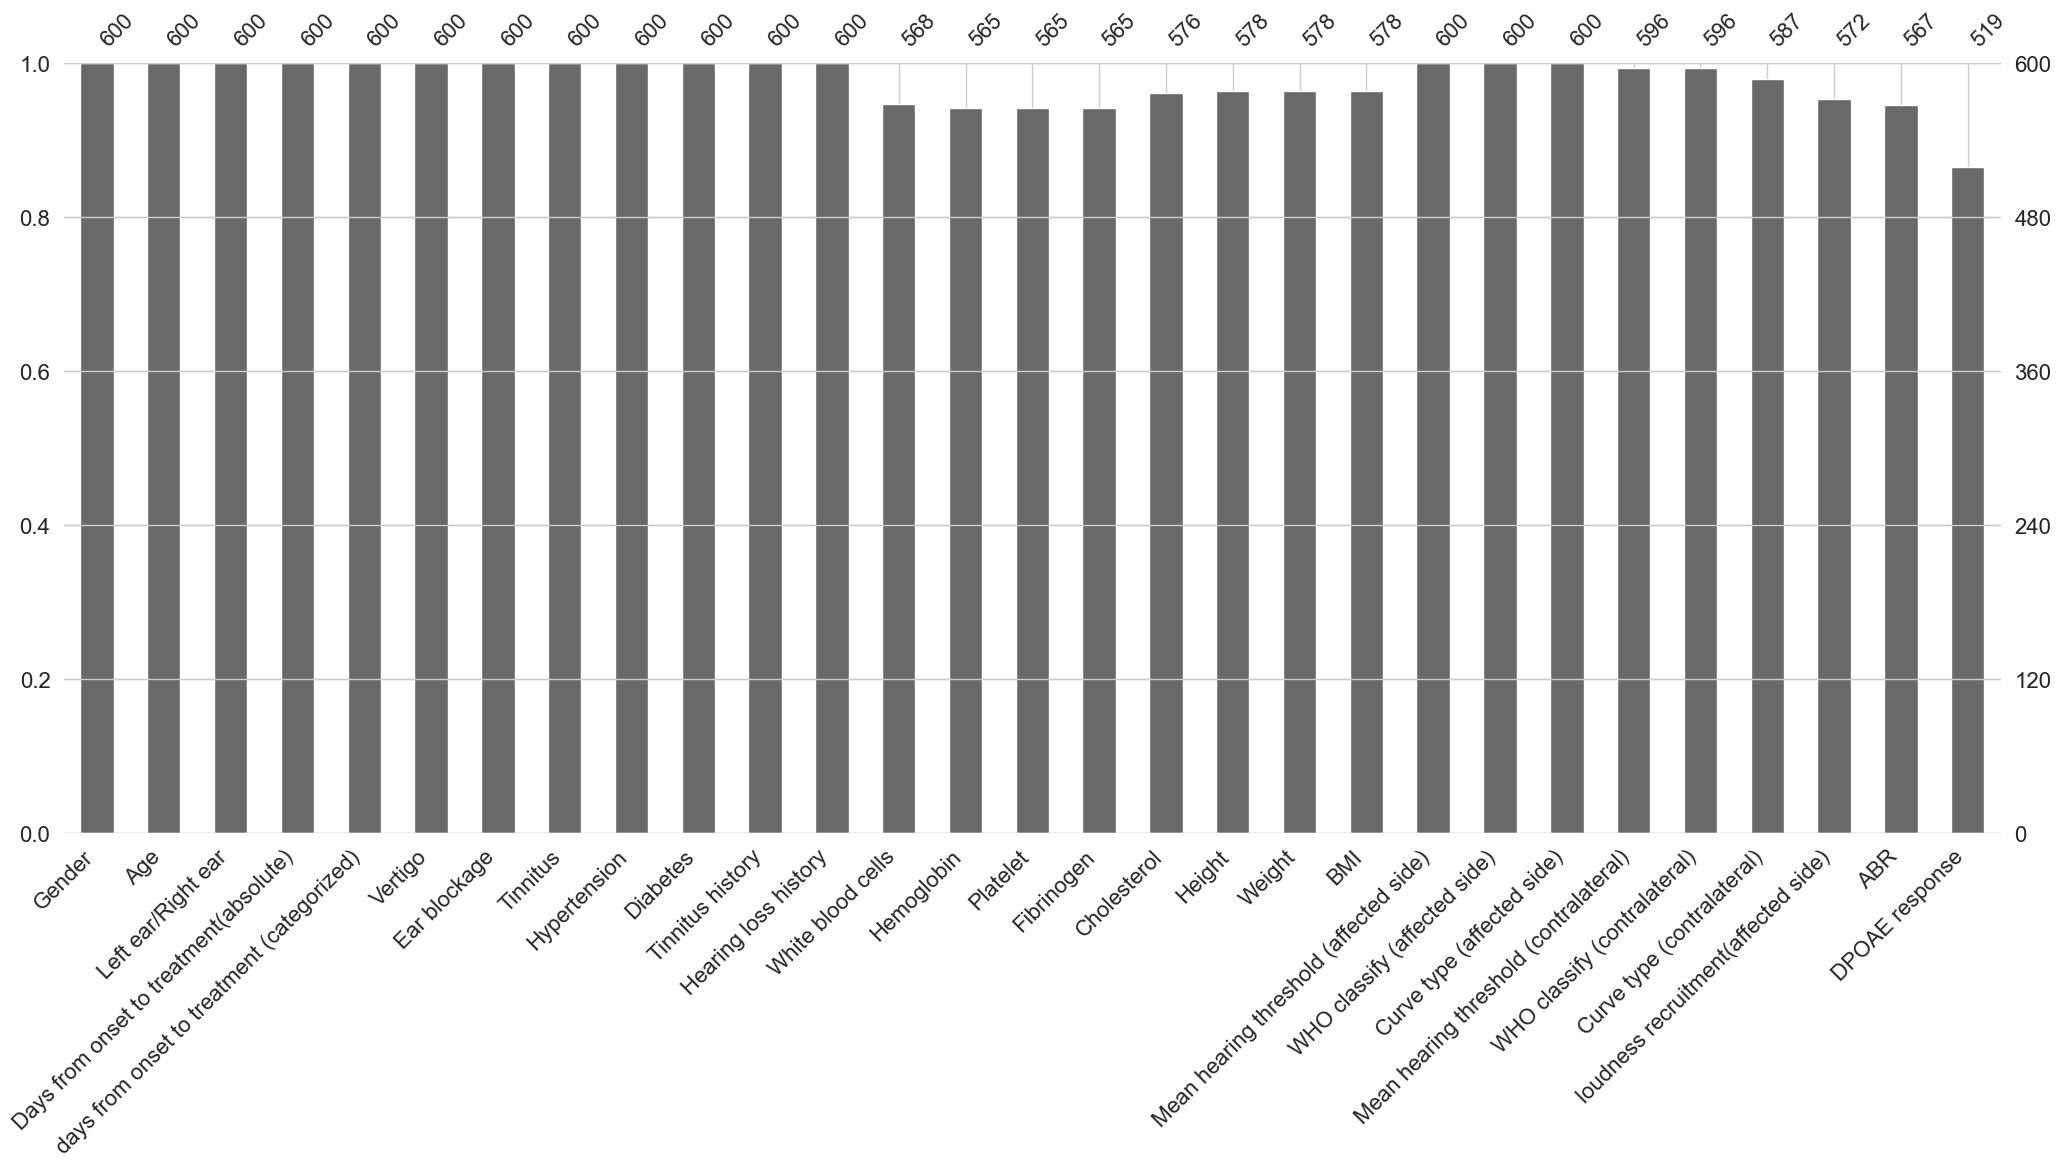

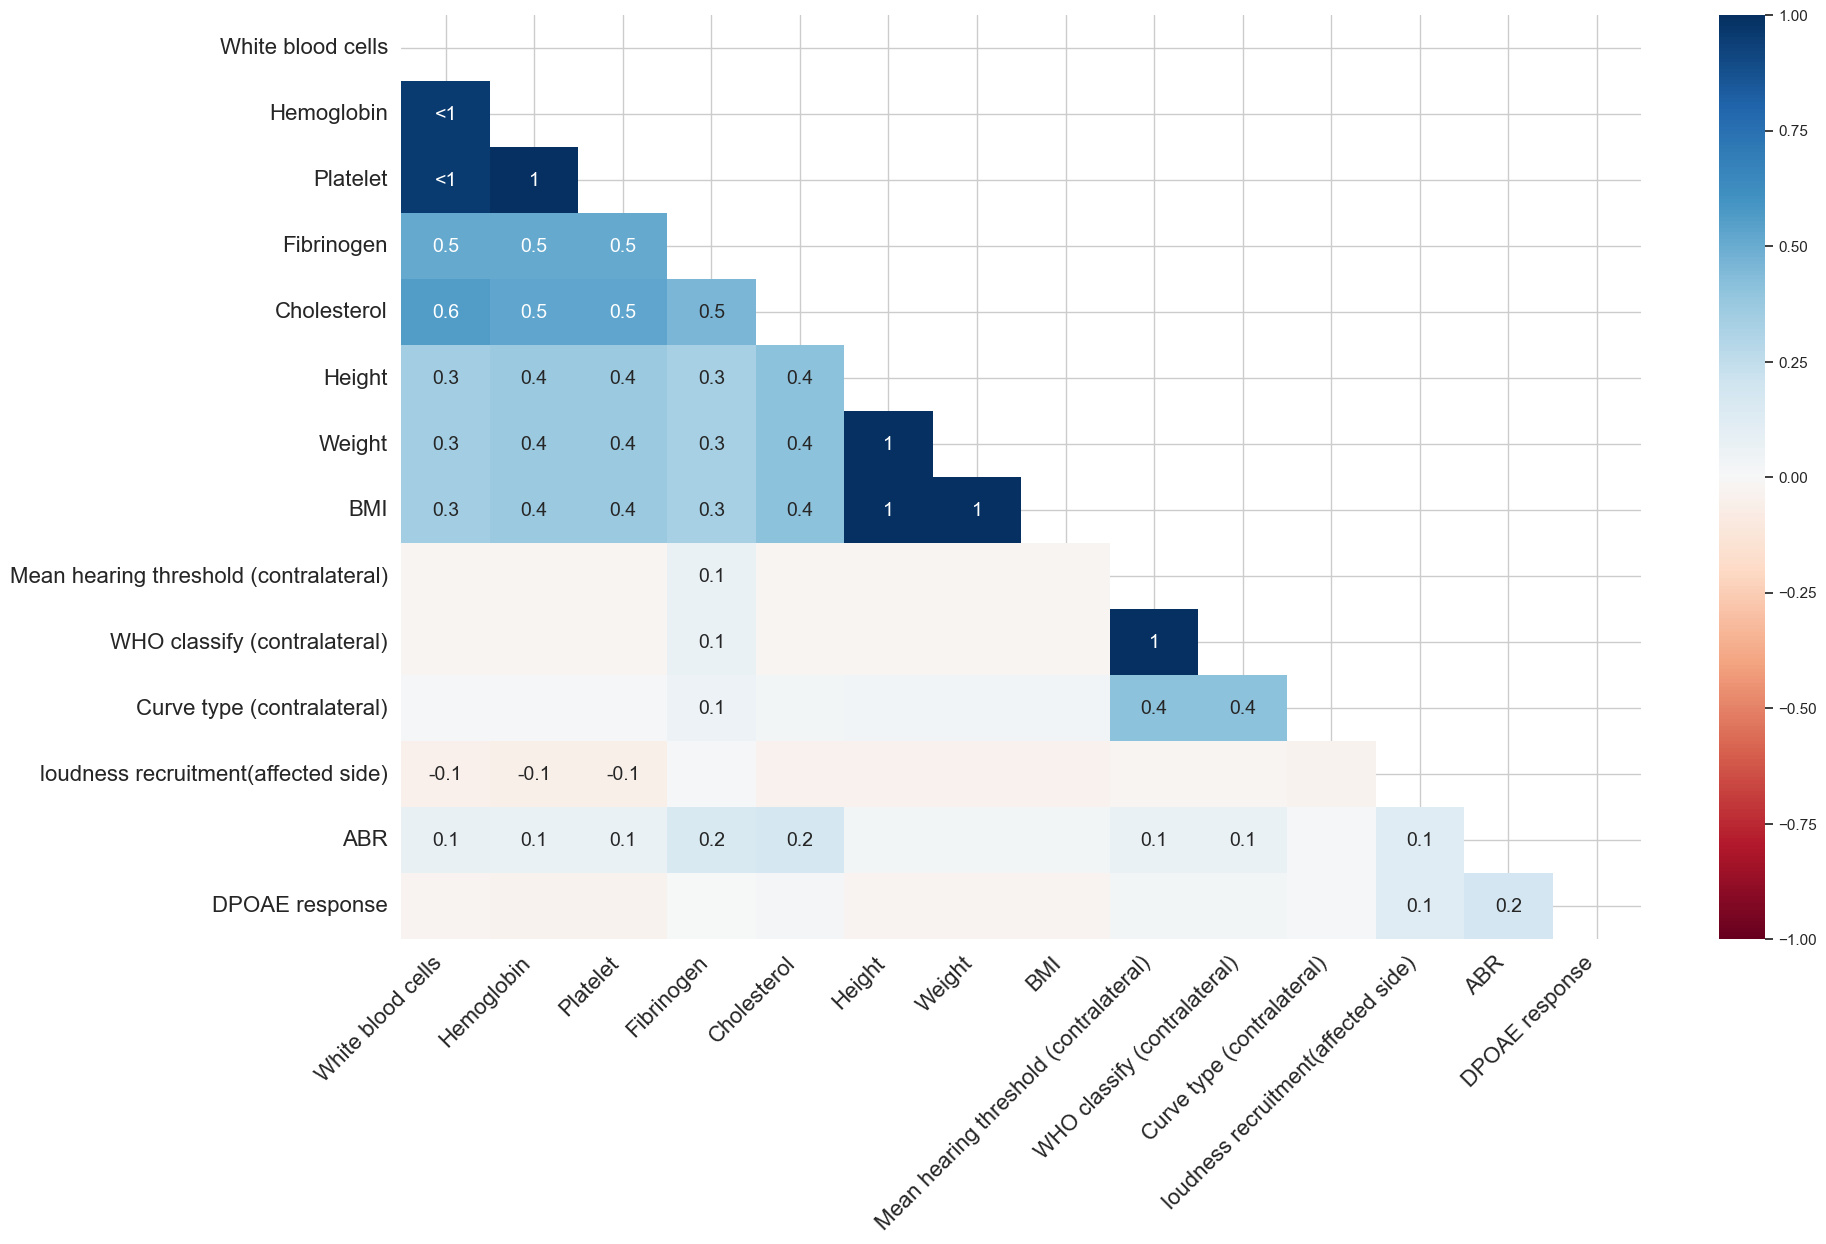

In [11]:
import missingno as msno


_data = data.drop(['prognostic'], axis=1).copy()
_data.replace('-', pd.NA, inplace=True)

msno.matrix(_data)
plt.savefig('../output/distribution/msno_matrix.pdf', bbox_inches="tight")
plt.show()

msno.bar(_data)
plt.savefig('../output/distribution/msno_bar.pdf', bbox_inches="tight")
plt.show()

msno.heatmap(_data)
plt.savefig('../output/distribution/msno_heatmap.pdf', bbox_inches="tight")
plt.show()

/var/folders/5c/gy4tbw190_j8c83t7cch98pc0000gn/T/ipykernel_63842/1832655613.py:33: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  mcar_matrix.loc[var, tvar] = ttest_ind(part_one.tolist(), part_two.tolist(), equal_var=False).pvalue
/Users/liminghong/anaconda3/envs/SSNHL/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/liminghong/anaconda3/envs/SSNHL/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1253: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,Gender,Age,Left ear/Right ear,Days from onset to treatment(absolute),days from onset to treatment (categorized),Vertigo,Ear blockage,Tinnitus,Hypertension,Diabetes,...,BMI,Mean hearing threshold (affected side),WHO classify (affected side),Curve type (affected side),Mean hearing threshold (contralateral),WHO classify (contralateral),Curve type (contralateral),loudness recruitment(affected side),ABR,DPOAE response
feature,,,,,,,,,,,,,,,,,,,,,
White blood cells,0.261428,0.286859,4.302245e-01,0.440499,0.466788,1.475911e-01,0.027669,0.046618,6.730026e-01,1.429767e-01,...,0.535423,0.215750,0.029088,0.391634,0.733134,0.641923,0.349460,0.172254,0.533175,0.141729
Hemoglobin,0.385012,0.227737,5.535570e-01,0.659326,0.758158,8.670011e-02,0.072848,0.024979,8.505857e-01,9.300768e-02,...,0.452444,0.223282,0.015366,0.387616,0.704708,0.503316,0.307962,0.200826,0.401989,0.061948
Platelet,0.385012,0.227737,5.535570e-01,0.659326,0.758158,8.670011e-02,0.072848,0.024979,8.505857e-01,9.300768e-02,...,0.452444,0.223282,0.015366,0.387616,0.704708,0.503316,0.307962,0.200826,0.401989,0.061948
Fibrinogen,0.603703,0.067584,8.023182e-01,0.593365,0.630063,1.642905e-01,0.509512,0.024979,4.936479e-01,9.300768e-02,...,0.208881,0.101650,0.018484,0.776803,0.921731,0.754138,0.544804,0.010589,0.169899,0.031204
Cholesterol,0.896769,0.831649,7.336938e-01,0.308443,0.408558,1.289417e-01,0.617641,0.198654,7.650955e-01,3.842828e-01,...,0.565772,0.222365,0.273132,0.689800,0.231200,0.332227,0.174631,0.056747,0.976576,0.482258
Height,0.269225,0.210978,7.192865e-01,0.618934,0.838519,2.339207e-03,0.881186,0.270259,3.562705e-01,8.395200e-01,...,NaN,0.087536,0.101369,0.993526,0.385984,0.632110,0.512240,0.021312,0.341502,0.199658
Weight,0.269225,0.210978,7.192865e-01,0.618934,0.838519,2.339207e-03,0.881186,0.270259,3.562705e-01,8.395200e-01,...,NaN,0.087536,0.101369,0.993526,0.385984,0.632110,0.512240,0.021312,0.341502,0.199658
BMI,0.269225,0.210978,7.192865e-01,0.618934,0.838519,2.339207e-03,0.881186,0.270259,3.562705e-01,8.395200e-01,...,NaN,0.087536,0.101369,0.993526,0.385984,0.632110,0.512240,0.021312,0.341502,0.199658
Mean hearing threshold (contralateral),0.438404,0.427901,9.409210e-91,0.861551,0.578417,4.099803e-56,0.532424,0.580868,3.286978e-28,2.785898e-12,...,0.288649,0.697022,0.902243,0.824837,NaN,NaN,NaN,0.796889,0.566432,0.971264


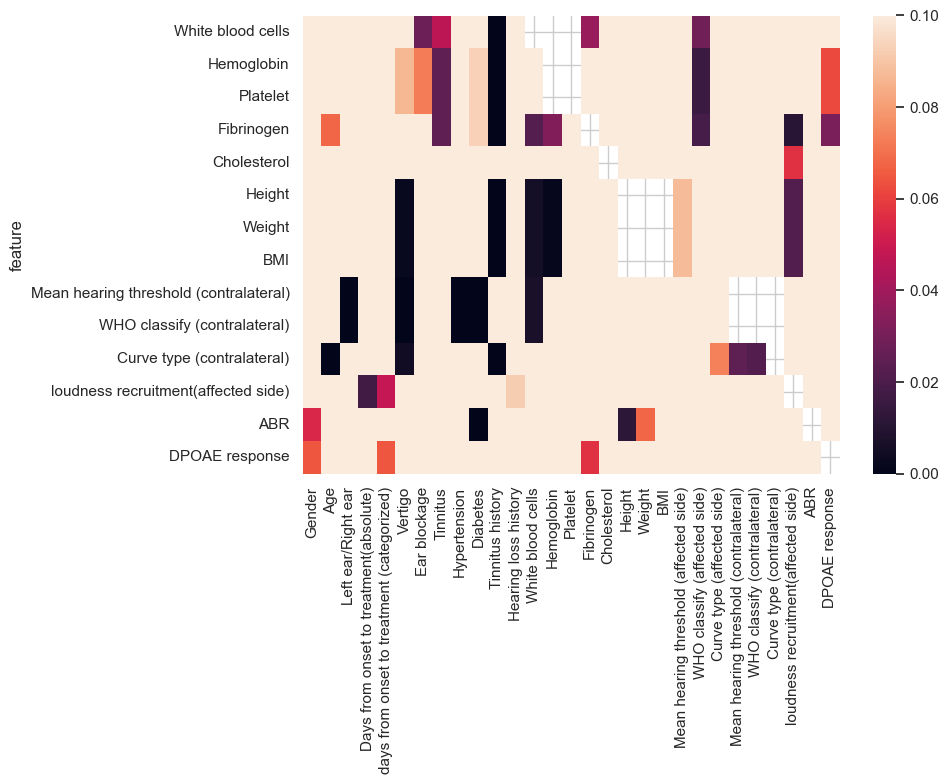

In [12]:
import numpy as np
from scipy.stats import ttest_ind

from SSNHL.util import Preprocess


def mcar_t_tests(X, missing_columns: list) -> pd.DataFrame:
    """
    Performs t-tests for MCAR for each pair of features.

    Parameters
    ----------
    X : Matrix of shape `(n, m)`
        Dataset with missing values. `n` rows (samples) and `m` columns (features).

    Returns
    -------
    pvalues : pandas DataFrame of shape `(m, m)`
        The p-values of t-tests for each pair of features. Null hypothesis for cell :math:`pvalues[h,j]`: data in feature :math:`h` is Missing Completely At Random (MCAR) with respect to feature :math:`j` for all :math:`h,j` in :math:`{1,2,...m}`. Diagonal values do not exist. 
    """
    dataset = X.copy()
    vars = dataset.dtypes.index.values
    mcar_matrix = pd.DataFrame(
        data=np.zeros(shape=(len(missing_columns), len(vars))),
        columns=vars,
        index=missing_columns,
    )

    for var in missing_columns:
        for tvar in vars:
            part_one = dataset.loc[dataset[var].isnull(), tvar].dropna()
            part_two = dataset.loc[~dataset[var].isnull(), tvar].dropna()
            mcar_matrix.loc[var, tvar] = ttest_ind(part_one.tolist(), part_two.tolist(), equal_var=False).pvalue

    return mcar_matrix[mcar_matrix.notnull()]


_data = Preprocess()._common_process(_data)
t_tests_matrix = mcar_t_tests(_data, df.index)


display(t_tests_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(t_tests_matrix, vmin=0, vmax=0.1)

plt.tight_layout()
plt.savefig('../output/distribution/mcar_t_tests.pdf', bbox_inches="tight")
plt.show()